In [4]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 12.0]

In [6]:
import pandas as pd
import numpy as np
import datetime as dt

In [7]:
from pandas_summary import DataFrameSummary

In [8]:
# import my Finance Analysis Tools (fat)
import finance as fat

In [9]:
# full imports of fastai fail on windows, so just import some of it for now
from fastai.structured import add_datepart, apply_cats, proc_df

<b>Don't run this on windows, only on paperspace...

In [10]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

### Create Data

Load a ticker to get a realistic date index

In [409]:
TICKER = 'IAU'
PATH = f'data/{TICKER}-test'

In [410]:
data = fat.get_price_data(TICKER)
data.head()

Loaded data for IAU: 2005-01-28 to 2018-02-26.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-28,4.273,4.273,4.246,4.269,4.269,5777000
2005-01-31,4.223,4.231,4.199,4.227,4.227,1519000
2005-02-01,4.211,4.214,4.197,4.212,4.212,695000
2005-02-02,4.223,4.223,4.204,4.223,4.223,2993000
2005-02-03,4.158,4.174,4.151,4.172,4.172,1068000


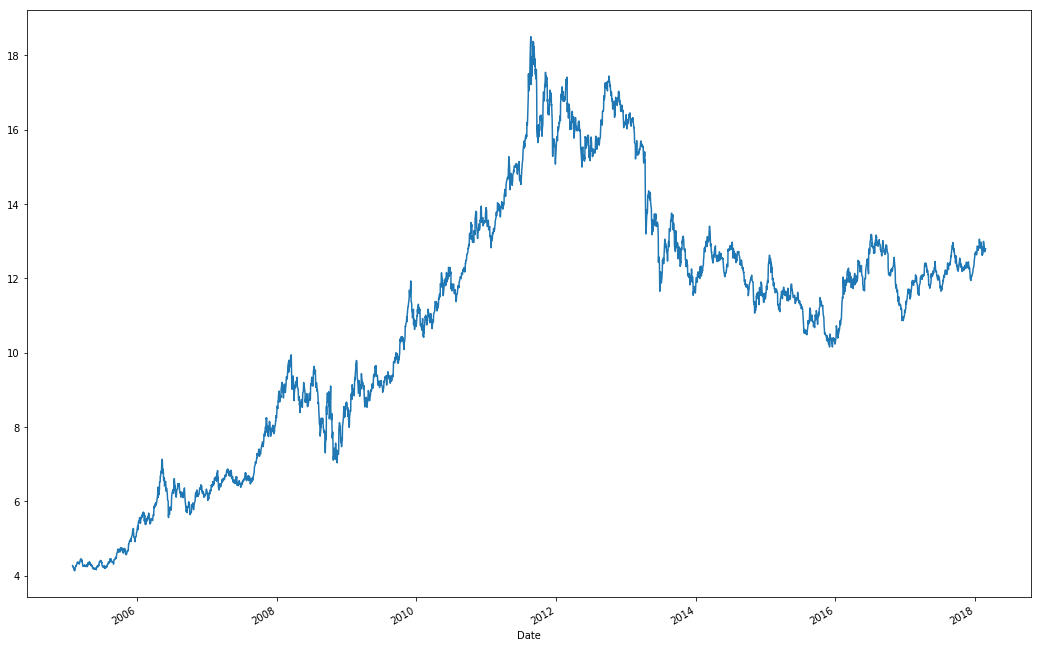

In [411]:
data['Adj Close'].plot()

In [412]:
data = data.reset_index()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-28,4.273,4.273,4.246,4.269,4.269,5777000
1,2005-01-31,4.223,4.231,4.199,4.227,4.227,1519000
2,2005-02-01,4.211,4.214,4.197,4.212,4.212,695000
3,2005-02-02,4.223,4.223,4.204,4.223,4.223,2993000
4,2005-02-03,4.158,4.174,4.151,4.172,4.172,1068000


In [413]:
for i in range(-2, 0, 1) :
    data[f'Adj Close {i}d'] = data['Adj Close'].shift(-i)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close -2d,Adj Close -1d
0,2005-01-28,4.273,4.273,4.246,4.269,4.269,5777000,NaN,NaN
1,2005-01-31,4.223,4.231,4.199,4.227,4.227,1519000,NaN,4.269
2,2005-02-01,4.211,4.214,4.197,4.212,4.212,695000,4.269,4.227
3,2005-02-02,4.223,4.223,4.204,4.223,4.223,2993000,4.227,4.212
4,2005-02-03,4.158,4.174,4.151,4.172,4.172,1068000,4.212,4.223


In [414]:
del data['Open']
del data['Low']
del data['High']
del data['Close']
del data['Volume']

In [415]:
#data['Open'] = data['Adj Close -1d']
#data['Low'] = data['Open']
#data['High'] = data['Adj Close']
#data['Close'] = data['Adj Close']
#data['Volume'] = 0

In [416]:
data = data.set_index('Date')
data = data.dropna()
data.head()

,Adj Close,Adj Close -2d,Adj Close -1d
Date,,,
2005-02-01,4.212,4.269,4.227
2005-02-02,4.223,4.227,4.212
2005-02-03,4.172,4.212,4.223
2005-02-04,4.150,4.223,4.172
2005-02-07,4.135,4.172,4.150


## Create Features

In [417]:
#data = fat.create_dl_features_df(data)

In [418]:
data = data.dropna()
data[-14:].T

Date,2018-02-06 00:00:00,2018-02-07 00:00:00,2018-02-08 00:00:00,2018-02-09 00:00:00,2018-02-12 00:00:00,2018-02-13 00:00:00,2018-02-14 00:00:00,2018-02-15 00:00:00,2018-02-16 00:00:00,2018-02-20 00:00:00,2018-02-21 00:00:00,2018-02-22 00:00:00,2018-02-23 00:00:00,2018-02-26 00:00:00
Adj Close,12.69,12.62,12.65,12.63,12.68,12.76,12.98,12.99,12.95,12.77,12.71,12.79,12.77,12.79
Adj Close -2d,12.80,12.85,12.69,12.62,12.65,12.63,12.68,12.76,12.98,12.99,12.95,12.77,12.71,12.79
Adj Close -1d,12.85,12.69,12.62,12.65,12.63,12.68,12.76,12.98,12.99,12.95,12.77,12.71,12.79,12.77


We're going to try to predict 'Adj Close' price tomorrow, so add a column with that info.

In [419]:
data['Adj Close +1d'] = data['Adj Close'].shift(-1)
data['Closed Higher Than Prev Close'] = data['Adj Close'] > data['Adj Close -1d']
#del data['Elapsed']
data.head().T

Date,2005-02-01 00:00:00,2005-02-02 00:00:00,2005-02-03 00:00:00,2005-02-04 00:00:00,2005-02-07 00:00:00
Adj Close,4.212,4.223,4.172,4.15,4.135
Adj Close -2d,4.269,4.227,4.212,4.223,4.172
Adj Close -1d,4.227,4.212,4.223,4.172,4.15
Adj Close +1d,4.223,4.172,4.15,4.135,4.129
Closed Higher Than Prev Close,False,True,False,False,False


In [420]:
data = data.dropna()

In [421]:
DataFrameSummary(data).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Adj Close,3289,10.8684,3.45241,4.129,8.415,11.63,12.81,18.5,3289,1782,0,0%,numeric
Adj Close -2d,3289,10.8632,3.45594,4.129,8.391,11.63,12.81,18.5,3289,1784,0,0%,numeric
Adj Close -1d,3289,10.8658,3.45419,4.129,8.402,11.63,12.81,18.5,3289,1783,0,0%,numeric
Adj Close +1d,3289,10.871,3.45062,4.129,8.434,11.64,12.81,18.5,3289,1782,0,0%,numeric
Closed Higher Than Prev Close,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3289,2,0,0%,bool


In [422]:
#del data['Year']
#del data['Elapsed']
data.columns

Index(['Adj Close', 'Adj Close -2d', 'Adj Close -1d', 'Adj Close +1d',
       'Closed Higher Than Prev Close'],
      dtype='object')

Break the columns up into "category variables" and "continuous variables".

In [423]:
cat_vars = ['Closed Higher Than Prev Close'] #'Days Since Trading', 'Days Until Trading', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            #'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

contin_vars = ['Adj Close', 'Adj Close -2d', 'Adj Close -1d'] 
              #['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Adj Close -10d',
              # 'Adj Close -9d', 'Adj Close -8d', 'Adj Close -7d', 'Adj Close -6d', 'Adj Close -5d',
              # 'Adj Close -4d', 'Adj Close -3d', 'Adj Close -2d', 'Adj Close -1d',
              # 'Year']


In [424]:
print(f'len(cat_vars) = {len(cat_vars)}')
print(f'len(contin_vars) = {len(contin_vars)}')
print(f'len(data.columns) = {len(data.columns)}')
assert(len(data.columns) == (len(cat_vars) + len(contin_vars) + 1))

len(cat_vars) = 1
len(contin_vars) = 3
len(data.columns) = 5


Split data into train and test sets.

In [425]:
data_len = len(data)
train_len = int(data_len * .8)
data_train = data[:train_len].copy()
data_test = data[train_len:].copy()

In [426]:
dep = 'Adj Close +1d'
data_train = data_train.reset_index()
data_train = data_train[cat_vars+contin_vars+[dep, 'Date']].copy()

In [427]:
data_train.tail().T

,2626,2627,2628,2629,2630
Closed Higher Than Prev Close,True,True,False,False,False
Adj Close,11.23,11.24,11.2,11.17,11.1
Adj Close -2d,11.18,11.21,11.23,11.24,11.2
Adj Close -1d,11.21,11.23,11.24,11.2,11.17
Adj Close +1d,11.24,11.2,11.17,11.1,11.06
Date,2015-07-09 00:00:00,2015-07-10 00:00:00,2015-07-13 00:00:00,2015-07-14 00:00:00,2015-07-15 00:00:00


In [428]:
data_test[dep] = 0
data_test = data_test.reset_index()
data_test = data_test[cat_vars+contin_vars+[dep,'Date']].copy()

In [429]:
data_test.head().T

,0,1,2,3,4
Closed Higher Than Prev Close,False,False,False,False,False
Adj Close,11.06,10.95,10.65,10.62,10.56
Adj Close -2d,11.17,11.1,11.06,10.95,10.65
Adj Close -1d,11.1,11.06,10.95,10.65,10.62
Adj Close +1d,0,0,0,0,0
Date,2015-07-16 00:00:00,2015-07-17 00:00:00,2015-07-20 00:00:00,2015-07-21 00:00:00,2015-07-22 00:00:00


In [430]:
data_train = data_train.dropna()
data_test = data_test.dropna()

In [431]:
for v in cat_vars: 
    data_train[v] = data_train[v].astype('category').cat.as_ordered()

In [432]:
apply_cats(data_test, data_train)

In [433]:
for v in contin_vars:
    data_train[v] = data_train[v].astype('float32')
    data_test[v] = data_test[v].astype('float32')

In [434]:
DataFrameSummary(data_train).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Closed Higher Than Prev Close,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2631,2,0,0%,bool
Adj Close,2631,10.6161,3.80031,4.129,7.054,11.27,13.28,18.5,2631,1710,0,0%,numeric
Adj Close -2d,2631,10.6109,3.80434,4.129,7.0435,11.27,13.28,18.5,2631,1712,0,0%,numeric
Adj Close -1d,2631,10.6135,3.80234,4.129,7.053,11.27,13.28,18.5,2631,1711,0,0%,numeric
Adj Close +1d,2631,10.6187,3.79827,4.129,7.08,11.27,13.28,18.5,2631,1710,0,0%,numeric
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2631,2631,0,0%,date


We can now process our data...

In [435]:
# we get a AttributeError here if we don't have skip_flds = ['Date']
data_train = data_train.set_index('Date')
df_train, y, nas, mapper = proc_df(data_train, dep, do_scale=True)
yl = np.log(y)

In [436]:
df_train.head(2).T

Date,2005-02-01 00:00:00,2005-02-02 00:00:00
Closed Higher Than Prev Close,1.000000,2.000000
Adj Close,-1.685475,-1.682580
Adj Close -2d,-1.667330,-1.678372
Adj Close -1d,-1.679943,-1.683888


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [437]:
train_ratio = 0.75
data_size = len(df_train)
train_size = int(data_size * train_ratio)
val_idx = list(range(train_size, data_size))

In [438]:
data_test = data_test.set_index('Date')
df_test, _, nas, mapper = proc_df(data_test, dep, do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [439]:
#joined = joined.dropna()
#joined_test = joined_test.dropna()

## Deep Learning

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [440]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [441]:
# before: bs=128, changed to bs=8 to get results while finding learning rate
md = ColumnarModelData.from_data_frame(PATH, val_idx, df_train, yl.astype(np.float32), cat_flds=cat_vars, bs=8,
                                       test_df=df_test)

Create categorical variables.

In [442]:
cat_sz = [(c, len(data_train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('Closed Higher Than Prev Close', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [443]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(3, 2)]

Find learning rate.

In [444]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [445]:
m.lr_find(1e-7, 1e-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.155589   0.390678  



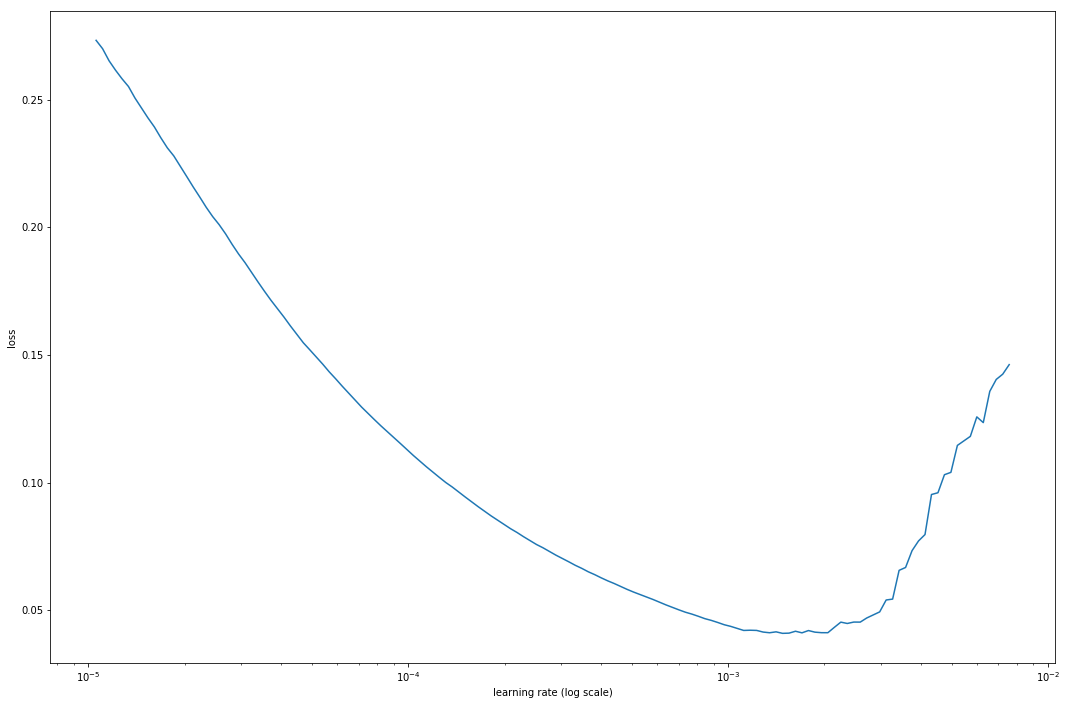

In [446]:
m.sched.plot(100)

### Sample

In [447]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4

In [448]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                     
    0      0.010044   0.001433   0.0361    
    1      0.012332   0.005455   0.068903                      
    2      0.010619   0.002413   0.049301                       



[0.002413233, 0.04930145897398722]

In [449]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.005153   0.000246   0.015228  
    1      0.00408    0.000223   0.014215                       
    2      0.004254   0.000382   0.018438                       



[0.00038209048, 0.01843784120822987]

In [450]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.007175   0.000874   0.02632   
    1      0.004759   0.000274   0.015669                       
    2      0.002999   0.000191   0.012844                       
    3      0.002396   0.000195   0.013479                       
    4      0.00782    0.001242   0.0292                         
    5      0.002687   0.000255   0.015424                       
    6      0.001844   0.000178   0.012511                       
    7      0.001463   0.000174   0.012326                       



[0.00017399741, 0.012326011224587315]

In [326]:
m.fit(lr, 1, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.004      0.002275   0.036542  



[0.0022746043, 0.0365415237055794]

In [ ]:
m.save('val0')

In [ ]:
m.load('val0')

In [451]:
x,y=m.predict_with_targs()

In [452]:
exp_rmspe(x,y)

0.013331149349906306

In [453]:
pred_test=m.predict(is_test=True)

In [454]:
pred_test = np.exp(pred_test)

In [455]:
data_test[dep]=pred_test

In [456]:
# prediction are made for the next day ('Date'+1), so shift data so that date is proper date for value predicted 
#predict = pd.DataFrame(data_test[dep].shift(1))
#predict.columns = [f'Predicted {TICKER} Price']
#predict[f'Actual {TICKER} Price'] = data['Adj Close']
#predict.dropna()
#predict['Prediction Error'] = predict[0] - predict[1]

In [457]:
predict = pd.DataFrame(data_test)

In [458]:
filename = f'{PATH}/{TICKER}-predictions-{dt.datetime.now():%Y%m%d-%H%M%S}.csv'
predict.to_csv(filename)

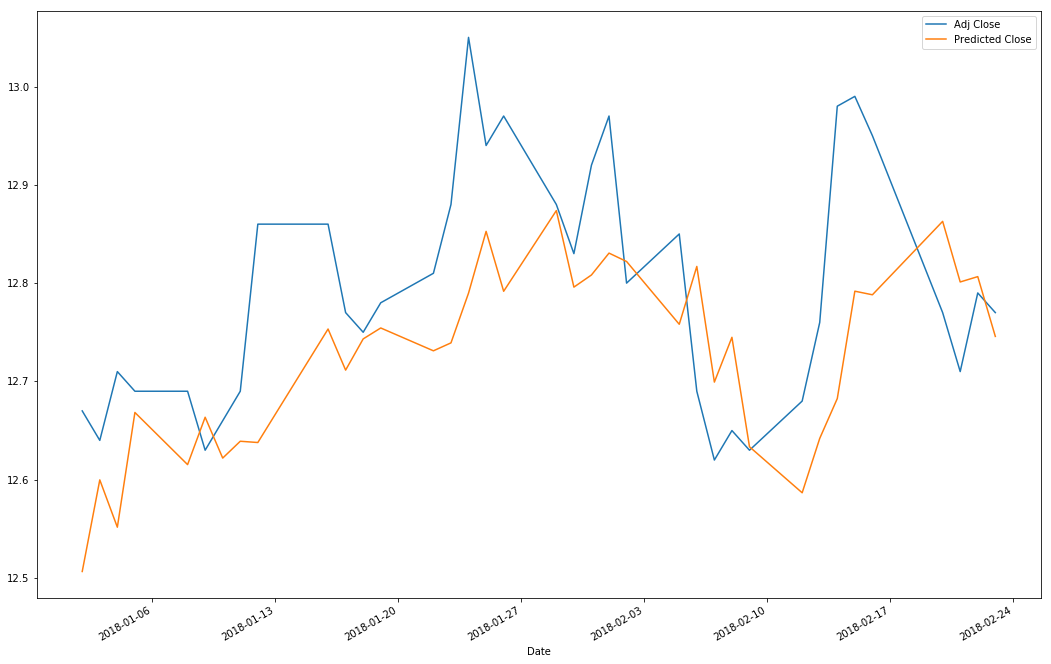

In [461]:
plot_data = pd.DataFrame(predict,columns=['Adj Close', 'Adj Close +1d'])
plot_data['Predicted Close'] = predict['Adj Close +1d'].shift(1)
del plot_data['Adj Close +1d']
plot_data['2018'].plot()

In [76]:
plot_data.tail()

,Adj Close,Adj Close +1d,Predicted Close
Date,,,
2018-02-16,12.95,12.824574,12.833479
2018-02-20,12.77,12.662870,12.824574
2018-02-21,12.71,12.562108,12.662870
2018-02-22,12.79,12.861712,12.562108
2018-02-23,12.77,12.773979,12.861712


In [397]:
m


MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(2, 1)
  )
  (lins): ModuleList(
    (0): Linear(in_features=12, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True)
)

In [77]:
rmse = np.sqrt(mean_squared_error(predict[0], predict[1]))
rmspe = rmse / len(predict)
#ex_rmspe = np.(rmspe)
print(f'RMSE = {rmse}')
print(f'RMSPE = {rmspe}')
#print(f'exp RMSPE = {ex_rmspe}')

NameError: name 'mean_squared_error' is not defined